# Chapter 11: Dense Vector Representations
## Singular Value Decomposition
Principal component analysis on characters of the _Salammbô_ novel by Flaubert with the French and English versions. 

Source of the texts: https://fr.wikisource.org/wiki/Salammb%C3%B4 and https://gutenberg.org/cache/epub/1290/pg1290-images.html

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statistics import mean, stdev
import pandas as pd
import torch

## The Dataset
We load and process the dataset to extract the letter counts per chapter. We use the chapters of the _Salammbô_ novel in French and English.

In [2]:
PATH = '../datasets/salammbo_chapters/'

### File Names

We first create a label for each chapter

In [3]:
np.set_printoptions(precision=4)


english_chapters = ['salammbo_en_ch01.txt', 'salammbo_en_ch02.txt', 'salammbo_en_ch03.txt',
                    'salammbo_en_ch04.txt', 'salammbo_en_ch05.txt', 'salammbo_en_ch06.txt',
                    'salammbo_en_ch07.txt', 'salammbo_en_ch08.txt', 'salammbo_en_ch09.txt',
                    'salammbo_en_ch10.txt', 'salammbo_en_ch11.txt', 'salammbo_en_ch12.txt',
                    'salammbo_en_ch13.txt', 'salammbo_en_ch14.txt', 'salammbo_en_ch15.txt']
french_chapters = ['salammbo_ch01.txt', 'salammbo_ch02.txt', 'salammbo_ch03.txt',
                   'salammbo_ch04.txt', 'salammbo_ch05.txt', 'salammbo_ch06.txt',
                   'salammbo_ch07.txt', 'salammbo_ch08.txt', 'salammbo_ch09.txt',
                   'salammbo_ch10.txt', 'salammbo_ch11.txt', 'salammbo_ch12.txt',
                   'salammbo_ch13.txt', 'salammbo_ch14.txt', 'salammbo_ch15.txt']

french_labels = [str(i + 1) + '_fr' for i in range(15)]
english_labels = [str(i + 1) + '_en' for i in range(15)]
y_name = french_labels + english_labels
y_name

['1_fr',
 '2_fr',
 '3_fr',
 '4_fr',
 '5_fr',
 '6_fr',
 '7_fr',
 '8_fr',
 '9_fr',
 '10_fr',
 '11_fr',
 '12_fr',
 '13_fr',
 '14_fr',
 '15_fr',
 '1_en',
 '2_en',
 '3_en',
 '4_en',
 '5_en',
 '6_en',
 '7_en',
 '8_en',
 '9_en',
 '10_en',
 '11_en',
 '12_en',
 '13_en',
 '14_en',
 '15_en']

### Document Indices
We create indices for the documents and two lookup dictionaries: document-to-index and index-to-document

Utility function

In [4]:
def build_idx_from_list(documents):
    """
    Builds indexes for the documents (rows)
    Build reverse index
    :param documents:
    :param chars:
    :return:
    """
    idx2doc = {idx: file for idx, file in enumerate(documents)}
    doc2idx = {value: key for key, value in idx2doc.items()}
    return doc2idx, idx2doc


def build_idx_from_dict(chars):
    """
    Builds indexes for the characters (columns)
    Build reverse index
    :param documents:
    :param chars:
    :return:
    """
    idx2char = {idx: char for idx, char in enumerate(sorted(chars.keys()))}
    char2idx = {value: key for key, value in idx2char.items()}
    return char2idx, idx2char

In [5]:
# We build a doc x char matrix, where each document is represented in the character space.
y = french_chapters + english_chapters
ec = [PATH + file for file in english_chapters]
fc = [PATH + file for file in french_chapters]
# Document index and reverse index
doc2idx, idx2doc = build_idx_from_list(y)
print(doc2idx)
print(idx2doc)

{'salammbo_ch01.txt': 0, 'salammbo_ch02.txt': 1, 'salammbo_ch03.txt': 2, 'salammbo_ch04.txt': 3, 'salammbo_ch05.txt': 4, 'salammbo_ch06.txt': 5, 'salammbo_ch07.txt': 6, 'salammbo_ch08.txt': 7, 'salammbo_ch09.txt': 8, 'salammbo_ch10.txt': 9, 'salammbo_ch11.txt': 10, 'salammbo_ch12.txt': 11, 'salammbo_ch13.txt': 12, 'salammbo_ch14.txt': 13, 'salammbo_ch15.txt': 14, 'salammbo_en_ch01.txt': 15, 'salammbo_en_ch02.txt': 16, 'salammbo_en_ch03.txt': 17, 'salammbo_en_ch04.txt': 18, 'salammbo_en_ch05.txt': 19, 'salammbo_en_ch06.txt': 20, 'salammbo_en_ch07.txt': 21, 'salammbo_en_ch08.txt': 22, 'salammbo_en_ch09.txt': 23, 'salammbo_en_ch10.txt': 24, 'salammbo_en_ch11.txt': 25, 'salammbo_en_ch12.txt': 26, 'salammbo_en_ch13.txt': 27, 'salammbo_en_ch14.txt': 28, 'salammbo_en_ch15.txt': 29}
{0: 'salammbo_ch01.txt', 1: 'salammbo_ch02.txt', 2: 'salammbo_ch03.txt', 3: 'salammbo_ch04.txt', 4: 'salammbo_ch05.txt', 5: 'salammbo_ch06.txt', 6: 'salammbo_ch07.txt', 7: 'salammbo_ch08.txt', 8: 'salammbo_ch09.txt

### Character Counts
We count the characters per chapter

In [6]:
def count_letters(text, lc=True):
    letter_count = {}
    if lc:
        text = text.lower()
    for letter in text:
        if letter.lower().isalpha():
            if letter in letter_count:
                letter_count[letter] += 1
            else:
                letter_count[letter] = 1
    return letter_count

In [7]:
counts_by_chapter = []
for file in fc + ec:
    text = open(file).read()
    counts = count_letters(text)
    counts_by_chapter.append(counts)
counts_by_chapter

[{'l': 1946,
  'e': 4312,
  'f': 264,
  's': 2996,
  't': 1938,
  'i': 1945,
  'n': 1896,
  'c': 857,
  'é': 423,
  'a': 2503,
  'à': 128,
  'm': 726,
  'g': 349,
  'r': 1948,
  'u': 1792,
  'b': 365,
  'o': 1372,
  'd': 1151,
  'h': 295,
  'j': 65,
  'q': 248,
  'v': 414,
  'p': 789,
  'y': 94,
  'x': 129,
  'î': 17,
  'z': 20,
  'è': 102,
  'ù': 14,
  'â': 36,
  'ê': 43,
  'ç': 35,
  'û': 7,
  'ô': 20,
  'œ': 5,
  'ï': 2,
  'k': 4,
  'ë': 1},
 {'à': 136,
  's': 3454,
  'i': 2345,
  'c': 1006,
  'a': 2992,
  'd': 1388,
  'e': 4993,
  'u': 2069,
  'x': 175,
  'j': 81,
  'o': 1560,
  'r': 2376,
  'p': 977,
  'è': 147,
  'l': 2128,
  'm': 823,
  'n': 2308,
  't': 2411,
  'h': 350,
  'g': 360,
  'v': 499,
  'é': 513,
  'q': 281,
  'ê': 68,
  'f': 319,
  'z': 23,
  'y': 89,
  'b': 391,
  'ô': 20,
  'k': 6,
  'â': 50,
  'œ': 5,
  'î': 20,
  'ç': 28,
  'û': 9,
  'ù': 9,
  'æ': 1},
 {'s': 1174,
  'a': 1042,
  'l': 816,
  'm': 397,
  'b': 152,
  'ô': 27,
  'u': 707,
  'n': 778,
  'e': 1785,
  

We compute the letter distribution across the chapters

In [8]:
def merge_dicts(dict_list):
    """
    Merges a list of dictionaries
    :param dict_list:
    :return:
    """
    dict_collector = {}
    for dict in dict_list:
        for key in dict:
            if key in dict_collector:
                dict_collector[key] += dict[key]
            else:
                dict_collector[key] = dict[key]
    return dict_collector

In [9]:
total_counts = merge_dicts(counts_by_chapter)
total_counts

{'l': 49802,
 'e': 136695,
 'f': 15588,
 's': 79656,
 't': 80132,
 'i': 64741,
 'n': 64813,
 'c': 26028,
 'é': 7709,
 'a': 81495,
 'à': 1884,
 'm': 25199,
 'g': 15214,
 'r': 63212,
 'u': 41660,
 'b': 13515,
 'o': 55353,
 'd': 41514,
 'h': 40959,
 'j': 1531,
 'q': 4356,
 'v': 11007,
 'p': 21954,
 'y': 7873,
 'x': 2846,
 'î': 277,
 'z': 866,
 'è': 2002,
 'ù': 179,
 'â': 605,
 'ê': 898,
 'ç': 452,
 'û': 213,
 'ô': 397,
 'œ': 96,
 'ï': 66,
 'k': 3556,
 'ë': 6,
 'æ': 9,
 'w': 11072}

### Character Indices
We associate the characters to unique indices

In [10]:
char2idx, idx2char = build_idx_from_dict(total_counts)
# Character index and reverse index
print(char2idx)
print(idx2char)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'à': 26, 'â': 27, 'æ': 28, 'ç': 29, 'è': 30, 'é': 31, 'ê': 32, 'ë': 33, 'î': 34, 'ï': 35, 'ô': 36, 'ù': 37, 'û': 38, 'œ': 39}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: 'à', 27: 'â', 28: 'æ', 29: 'ç', 30: 'è', 31: 'é', 32: 'ê', 33: 'ë', 34: 'î', 35: 'ï', 36: 'ô', 37: 'ù', 38: 'û', 39: 'œ'}


## Matrices
From the counts, we now create a document-by-character matrix.

In [11]:
def build_matrix(doc2idx, idx2doc, char2idx, idx2char, counts_by_chapter):
    X = np.zeros((len(doc2idx.keys()), len(char2idx.keys())))
    for i in sorted(idx2doc.keys()):
        for j in sorted(idx2char.keys()):
            if idx2char[j] in counts_by_chapter[i]:
                X[i, j] = counts_by_chapter[i][idx2char[j]]
    return X


def print_matrix(idx2doc, idx2char, X):
    print(",", end='')
    for i in idx2char.keys():
        print(idx2char[i], ", ", end='')
    print()
    for i in idx2doc.keys():
        print(idx2doc[i], ", ", end='')
        for j in idx2char.keys():
            print(X[i, j], ", ", end='')
        print()

In [12]:
X = build_matrix(doc2idx, idx2doc, char2idx, idx2char, counts_by_chapter)
# print_matrix(idx2doc, idx2char, X)
# print_matrix(idx2char, idx2doc, X.T)

In [13]:
pd.DataFrame(X, sorted(idx2doc.values()), sorted(idx2char.values()))

,a,b,c,d,e,f,g,h,i,j,...,è,é,ê,ë,î,ï,ô,ù,û,œ
salammbo_ch01.txt,2503.0,365.0,857.0,1151.0,4312.0,264.0,349.0,295.0,1945.0,65.0,...,102.0,423.0,43.0,1.0,17.0,2.0,20.0,14.0,7.0,5.0
salammbo_ch02.txt,2992.0,391.0,1006.0,1388.0,4993.0,319.0,360.0,350.0,2345.0,81.0,...,147.0,513.0,68.0,0.0,20.0,0.0,20.0,9.0,9.0,5.0
salammbo_ch03.txt,1042.0,152.0,326.0,489.0,1785.0,136.0,122.0,126.0,784.0,41.0,...,49.0,194.0,24.0,0.0,12.0,0.0,27.0,4.0,7.0,2.0
salammbo_ch04.txt,2487.0,303.0,864.0,1137.0,4158.0,314.0,331.0,287.0,2028.0,57.0,...,138.0,424.0,36.0,0.0,15.0,2.0,15.0,6.0,4.0,8.0
salammbo_ch05.txt,2014.0,268.0,645.0,949.0,3394.0,223.0,215.0,242.0,1617.0,67.0,...,112.0,367.0,44.0,1.0,11.0,8.0,23.0,18.0,15.0,7.0
salammbo_ch06.txt,2805.0,368.0,910.0,1266.0,4535.0,332.0,384.0,378.0,2219.0,97.0,...,122.0,548.0,57.0,0.0,15.0,12.0,15.0,14.0,15.0,9.0
salammbo_ch07.txt,5062.0,706.0,1770.0,2398.0,8512.0,623.0,622.0,620.0,4018.0,126.0,...,232.0,966.0,96.0,2.0,42.0,9.0,41.0,30.0,38.0,9.0
salammbo_ch08.txt,2643.0,325.0,869.0,1085.0,4229.0,307.0,317.0,359.0,2102.0,85.0,...,119.0,502.0,54.0,0.0,11.0,1.0,14.0,6.0,8.0,5.0
salammbo_ch09.txt,2126.0,289.0,771.0,920.0,3599.0,278.0,289.0,279.0,1805.0,52.0,...,99.0,370.0,43.0,1.0,8.0,2.0,13.0,5.0,15.0,3.0
salammbo_ch10.txt,1784.0,249.0,546.0,805.0,3002.0,179.0,202.0,215.0,1319.0,60.0,...,68.0,304.0,53.0,0.0,15.0,5.0,38.0,3.0,10.0,5.0


The character-by-document matrix is just a transpose of the previous matrix

In [14]:
pd.DataFrame(X.T, sorted(idx2char.values()), sorted(idx2doc.values()))

,salammbo_ch01.txt,salammbo_ch02.txt,salammbo_ch03.txt,salammbo_ch04.txt,salammbo_ch05.txt,salammbo_ch06.txt,salammbo_ch07.txt,salammbo_ch08.txt,salammbo_ch09.txt,salammbo_ch10.txt,...,salammbo_en_ch06.txt,salammbo_en_ch07.txt,salammbo_en_ch08.txt,salammbo_en_ch09.txt,salammbo_en_ch10.txt,salammbo_en_ch11.txt,salammbo_en_ch12.txt,salammbo_en_ch13.txt,salammbo_en_ch14.txt,salammbo_en_ch15.txt
a,2503.0,2992.0,1042.0,2487.0,2014.0,2805.0,5062.0,2643.0,2126.0,1784.0,...,2606.0,4805.0,2396.0,1993.0,1627.0,2375.0,2560.0,4597.0,4871.0,1119.0
b,365.0,391.0,152.0,303.0,268.0,368.0,706.0,325.0,289.0,249.0,...,518.0,913.0,431.0,408.0,359.0,437.0,489.0,987.0,948.0,229.0
c,857.0,1006.0,326.0,864.0,645.0,910.0,1770.0,869.0,771.0,546.0,...,797.0,1521.0,702.0,653.0,451.0,643.0,757.0,1462.0,1439.0,335.0
d,1151.0,1388.0,489.0,1137.0,949.0,1266.0,2398.0,1085.0,920.0,805.0,...,1509.0,2681.0,1416.0,1096.0,933.0,1364.0,1566.0,2689.0,2799.0,683.0
e,4312.0,4993.0,1785.0,4158.0,3394.0,4535.0,8512.0,4229.0,3599.0,3002.0,...,4237.0,7834.0,4014.0,3373.0,2690.0,3790.0,4331.0,7963.0,8179.0,1994.0
f,264.0,319.0,136.0,314.0,223.0,332.0,623.0,307.0,278.0,179.0,...,687.0,1366.0,621.0,575.0,477.0,610.0,677.0,1254.0,1335.0,323.0
g,349.0,360.0,122.0,331.0,215.0,384.0,622.0,317.0,289.0,202.0,...,669.0,1163.0,624.0,517.0,409.0,644.0,650.0,1201.0,1140.0,281.0
h,295.0,350.0,126.0,287.0,242.0,378.0,620.0,359.0,279.0,215.0,...,2254.0,4379.0,2171.0,1766.0,1475.0,2217.0,2348.0,4278.0,4534.0,1108.0
i,1945.0,2345.0,784.0,2028.0,1617.0,2219.0,4018.0,2102.0,1805.0,1319.0,...,2097.0,3838.0,2011.0,1648.0,1196.0,1830.0,2033.0,3634.0,3829.0,912.0
j,65.0,81.0,41.0,57.0,67.0,97.0,126.0,85.0,52.0,60.0,...,26.0,42.0,24.0,16.0,7.0,16.0,28.0,39.0,36.0,9.0


### Scaling the Matrices
We now scale the matrices to apply a principal component analysis

In [15]:
mean = np.mean(X[:, 0])
std = np.std(X[:, 0])
print('mean A:', mean, 'stdev A:', std)
print('Original:', X[0, 0], 'Standardized', (X[0, 0] - mean) / std)

# Boolean for normalization
normalize = True
# We scale the matrix
# This preprocessing combination seems to have the best results: normalize and standardize
if normalize:
    X_norm = Normalizer().fit_transform(X)
else:
    X_norm = X
X_scaled = StandardScaler().fit_transform(X_norm)

mean A: 2716.5 stdev A: 1236.2119761594288
Original: 2503.0 Standardized -0.17270500862100194


## Principal Component Analysis (PCA)
### Document-by-Character Matrix
We first apply the PCA to the document-by-character matrix. We illustrate it with three different APIs: sklean, NumPy, and PyTorch

### Computation with sklearn

In [16]:
pca = PCA(n_components=3)
X_trunc = pca.fit_transform(X_scaled)
print(X_trunc)

[[ 5.2199  0.376   0.6937]
 [ 5.125  -0.8897  1.6817]
 [ 5.1555  3.7735 -1.1216]
 [ 5.0176 -1.9599  0.5196]
 [ 6.6524  0.198  -1.3812]
 [ 5.5301 -1.6992 -1.6341]
 [ 5.4981 -0.479  -0.5495]
 [ 5.417  -2.2532 -0.449 ]
 [ 5.2669 -2.1786  1.7849]
 [ 5.5801  3.6995 -1.5625]
 [ 6.3973  1.3876 -3.7567]
 [ 4.6837 -3.0525  0.0156]
 [ 5.2072  0.2916  1.31  ]
 [ 5.3116 -1.5667  0.4665]
 [ 6.3454  3.7309  4.1498]
 [-5.2129  0.3976  1.4684]
 [-5.666   0.1537 -0.1098]
 [-5.5924 -0.6628 -1.7142]
 [-5.1102  0.4636  0.7549]
 [-5.8539  0.8692 -0.2062]
 [-5.4708 -1.2412 -0.3197]
 [-5.2463 -0.2334  0.139 ]
 [-5.0445 -1.5632  0.1945]
 [-5.3597 -0.9404  0.4364]
 [-5.7048  1.1977 -0.4483]
 [-5.6351  0.2643 -1.8299]
 [-5.7406 -0.5112 -0.1123]
 [-5.5443  0.8845  0.3861]
 [-5.5994  0.1346  0.0627]
 [-5.6271  1.4086  1.1312]]


### Visualizing the PCA

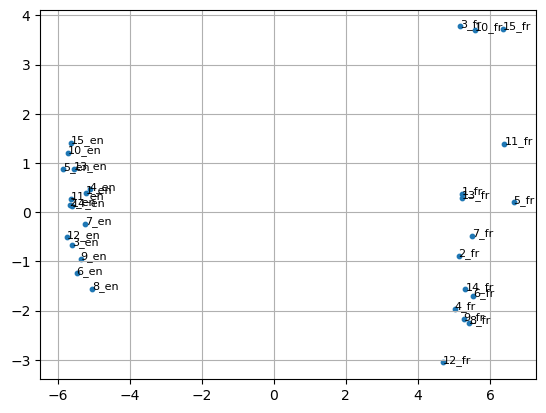

In [17]:
plt.scatter(X_trunc[:, 0], X_trunc[:, 1], s=10)
for i in range(len(y_name)):
    # plt.plot(X_trunc[i, 0], X_trunc[i, 1], 'o')
    plt.annotate(y_name[i], (X_trunc[i, 0], X_trunc[i, 1]), fontsize=8)
plt.grid(True)
plt.show()

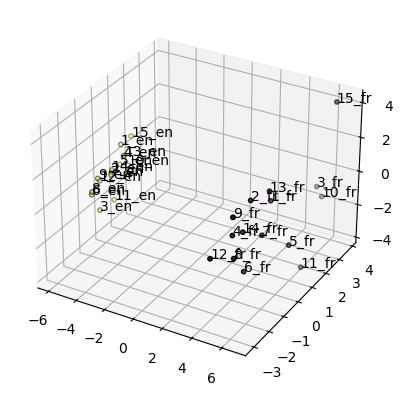

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_color = [0] * 15 + [1] * 15
ax.scatter(X_trunc[:, 0], X_trunc[:, 1], X_trunc[:, 2], c=y_color,
           edgecolor='k', s=10)
for i in range(len(y_name)):
    ax.text(X_trunc[i, 0], X_trunc[i, 1], X_trunc[i, 2], y_name[i])
plt.show()

### Computation with NumPy

In [19]:
U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
U.shape, Vt.shape

((30, 30), (30, 40))

In [20]:
s

array([3.0176e+01, 9.1895e+00, 7.7380e+00, 5.7478e+00, 4.7188e+00,
       4.4547e+00, 3.7848e+00, 3.5233e+00, 2.8713e+00, 2.5936e+00,
       2.4191e+00, 1.9188e+00, 1.7805e+00, 1.6744e+00, 1.5473e+00,
       1.4624e+00, 1.3425e+00, 1.1634e+00, 1.0730e+00, 1.0285e+00,
       8.5207e-01, 8.1268e-01, 6.5973e-01, 5.8636e-01, 4.8429e-01,
       3.7867e-01, 3.5378e-01, 3.1706e-01, 2.4558e-01, 1.3401e-14])

In [21]:
len(s)

30

In [22]:
cumulative_inertia = np.cumsum(s)
list(cumulative_inertia)[:10]

[30.17588172213514,
 39.36534367569337,
 47.10337246744758,
 52.85121879386235,
 57.57001777420634,
 62.024746542462125,
 65.8095292952526,
 69.33280697988624,
 72.20405700080552,
 74.79764984352416]

### Visualizing the Inertia

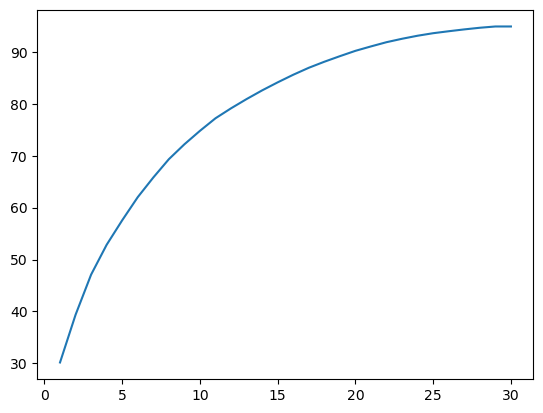

In [23]:
plt.clf()
plt.plot(range(1, len(cumulative_inertia) + 1), cumulative_inertia, '-')
plt.show()

### Visualizing the PCA

The new coordinates

In [24]:
Us = U @ np.diag(s)
# Axes may have opposed orientation. This is to have the same figure.
# You may have to change the sign
I = -np.identity(len(s))
Us = Us @ I
Us

array([[-5.2199e+00, -3.7597e-01,  6.9368e-01, -1.3015e+00,  1.9462e+00,
        -8.6375e-01,  1.0850e+00, -4.2106e-01,  5.2973e-01, -7.3063e-01,
         5.2021e-01, -3.9391e-01,  1.3296e-01,  2.8673e-01,  2.8287e-01,
        -3.4571e-01, -3.3255e-01, -9.9763e-02,  3.9680e-02,  8.5862e-02,
         3.9362e-02,  8.5278e-02,  1.6304e-01, -1.8185e-02, -1.2839e-01,
        -5.4934e-02, -7.3482e-03, -4.9339e-03, -9.1165e-03, -2.4466e-15],
       [-5.1250e+00,  8.8971e-01,  1.6817e+00,  9.6829e-01,  9.8747e-01,
        -3.3085e-01, -8.0757e-02,  3.3876e-01,  2.5214e-01, -2.8552e-01,
         4.4523e-01,  2.6785e-01,  3.3811e-01, -6.2304e-01,  2.0342e-01,
        -2.3196e-01,  3.9057e-01,  2.6097e-01, -2.4647e-02,  1.5150e-01,
         6.0495e-02, -3.4158e-02, -1.5649e-01, -1.8976e-01,  9.4315e-02,
         5.5438e-02,  4.3921e-02, -7.6442e-02, -5.2547e-02, -2.4466e-15],
       [-5.1555e+00, -3.7735e+00, -1.1216e+00,  2.0766e+00, -3.9316e-01,
         1.5437e-01,  1.1693e+00, -1.5354e+00, -2

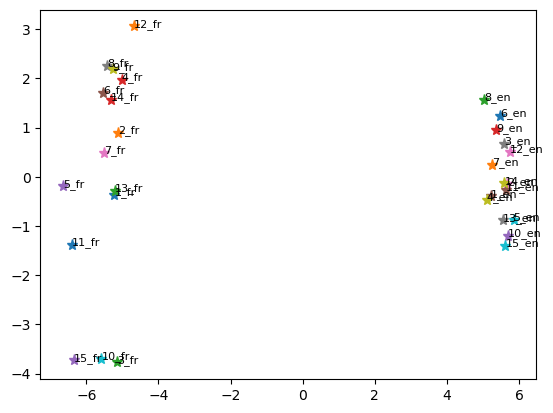

In [25]:
for i in range(len(y_name)):
    plt.plot(Us[i, 0], Us[i, 1], '*', markersize=8)
    plt.annotate(y_name[i], (Us[i, 0], Us[i, 1]), fontsize=8)
plt.show()

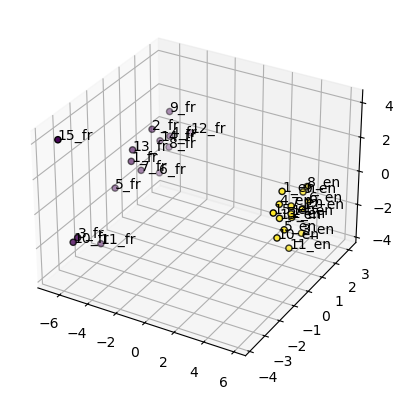

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_color = [0] * 15 + [1] * 15
ax.scatter(Us[:, 0], Us[:, 1], Us[:, 2], c=y_color,
           edgecolor='k')
for i in range(len(y_name)):
    ax.text(Us[i, 0], Us[i, 1], Us[i, 2], y_name[i])
plt.show()

### Computation with PyTorch

In [27]:
U, s, Vt = torch.linalg.svd(torch.from_numpy(X_scaled), full_matrices=False)
U.size(), Vt.size()

(torch.Size([30, 30]), torch.Size([30, 40]))

In [28]:
s

tensor([3.0176e+01, 9.1895e+00, 7.7380e+00, 5.7478e+00, 4.7188e+00, 4.4547e+00,
        3.7848e+00, 3.5233e+00, 2.8713e+00, 2.5936e+00, 2.4191e+00, 1.9188e+00,
        1.7805e+00, 1.6744e+00, 1.5473e+00, 1.4624e+00, 1.3425e+00, 1.1634e+00,
        1.0730e+00, 1.0285e+00, 8.5207e-01, 8.1268e-01, 6.5973e-01, 5.8636e-01,
        4.8429e-01, 3.7867e-01, 3.5378e-01, 3.1706e-01, 2.4558e-01, 1.3401e-14],
       dtype=torch.float64)

In [29]:
Us = U @ np.diag(s)
# Axes may have opposed orientation. This is to have the same figure
I = -np.identity(len(s))
Us = Us @ I
Us

tensor([[ 5.2199e+00,  3.7597e-01, -6.9368e-01,  1.3015e+00, -1.9462e+00,
          8.6375e-01, -1.0850e+00,  4.2106e-01, -5.2973e-01,  7.3063e-01,
         -5.2021e-01,  3.9391e-01, -1.3296e-01, -2.8673e-01, -2.8287e-01,
          3.4571e-01,  3.3255e-01,  9.9763e-02, -3.9680e-02, -8.5862e-02,
         -3.9362e-02, -8.5278e-02, -1.6304e-01,  1.8185e-02,  1.2839e-01,
          5.4934e-02,  7.3482e-03,  4.9339e-03,  9.1165e-03,  2.4466e-15],
        [ 5.1250e+00, -8.8971e-01, -1.6817e+00, -9.6829e-01, -9.8747e-01,
          3.3085e-01,  8.0757e-02, -3.3876e-01, -2.5214e-01,  2.8552e-01,
         -4.4523e-01, -2.6785e-01, -3.3811e-01,  6.2304e-01, -2.0342e-01,
          2.3196e-01, -3.9057e-01, -2.6097e-01,  2.4647e-02, -1.5150e-01,
         -6.0495e-02,  3.4158e-02,  1.5649e-01,  1.8976e-01, -9.4315e-02,
         -5.5438e-02, -4.3921e-02,  7.6442e-02,  5.2547e-02,  2.4466e-15],
        [ 5.1555e+00,  3.7735e+00,  1.1216e+00, -2.0766e+00,  3.9316e-01,
         -1.5437e-01, -1.1693e+00,  

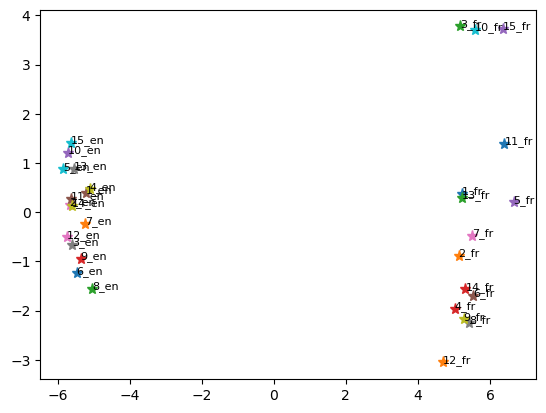

In [30]:
for i in range(len(y_name)):
    plt.plot(Us[i, 0], Us[i, 1], '*', markersize=8)
    plt.annotate(y_name[i], (Us[i, 0], Us[i, 1]), fontsize=8)
plt.show()

## Principal Component Analysis (PCA)
### Character-by-Document Matrix
We now transpose the matrix and we apply a PCA. Each character is represented in a space of documents

In [31]:
yt = sorted(list(char2idx.keys()))
yt

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'à',
 'â',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ']

In [32]:
X = X.T

In [33]:
if normalize:
    X_norm = Normalizer().fit_transform(X)
else:
    X_norm = X
X_scaled = StandardScaler().fit_transform(X_norm)
# X_std = StandardScaler().fit_transform(X)
U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
Us = U @ np.diag(s)
print(Us)

[[ 2.0965e+00 -1.3196e+00 -1.6675e-01 ... -5.5374e-03  1.0251e-02
   5.1177e-03]
 [ 3.9357e+00 -6.4946e-01 -3.2843e-02 ... -2.6933e-02 -2.4995e-02
   8.0939e-03]
 [ 1.5530e+00 -1.2752e+00 -3.2551e-01 ... -5.6586e-02  2.4135e-02
   7.7821e-03]
 ...
 [-4.7473e+00  1.2131e+00  7.1742e-01 ... -1.9608e-02 -2.8347e-04
  -1.7763e-03]
 [-4.7974e+00  1.6966e+00 -5.7373e-01 ...  2.0098e-02  2.2058e-03
   7.5350e-03]
 [-5.0900e+00  4.2584e-01  3.3339e-02 ... -2.0247e-03 -1.9797e-03
  -1.7471e-03]]


### Character Embeddings

### Visualization

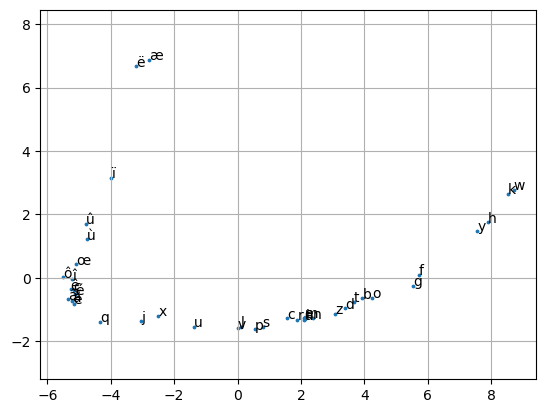

In [34]:
plt.grid(True)
plt.axis('equal')
plt.scatter(Us[:, 0], Us[:, 1], s=3)
for i in range(len(yt)):
    # plt.plot(Us[i, 0], Us[i, 1], 'bo',markersize=5)
    plt.annotate(yt[i], (Us[i, 0], Us[i, 1]))
plt.show()

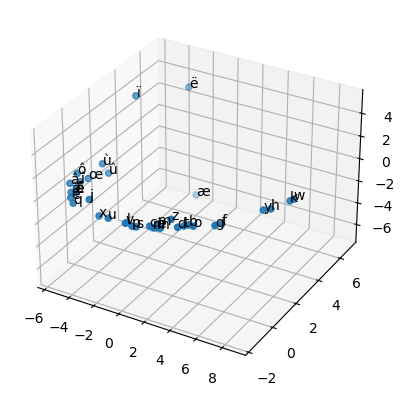

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Us[:, 0], Us[:, 1], Us[:, 2])
for i in range(len(yt)):
    ax.text(Us[i, 0], Us[i, 1], Us[i, 2], yt[i])
plt.show()